In [243]:
using Revise
using Pkg
using RCall
using StatsBase
using FreqTables
using BioSymbols
using DataFrames
R"""
library('ggplot2')
"""
Pkg.activate("/mnt/raid/covid-phylogeny/scripts/julia_modules/JuliaClusterAndTreeTools")
using JuliaClusterAndTreeTools

  Activating project at `/mnt/raid/covid-phylogeny/scripts/julia_modules/JuliaClusterAndTreeTools`


In [246]:
aln = JuliaClusterAndTreeTools.Alignment("/mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade_1000.fasta.gz")


Reading aligment /mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade_1000.fasta.gz


Reading alignment finished, 193 sequences were skipped due to atypical symbols



Alignment(["Scotland/QEUH-3C4E405/2022", "England/QEUH-3C5A530/2022", "Scotland/QEUH-3C5A7C1/2022", "England/ALDP-3C2902A/2022", "England/QEUH-3C5A8FB/2022", "Scotland/QEUH-3C2E7A8/2022", "England/PHEP-YYRT8NQ/2022", "Italy/EMR_AUSLRomagna_C030-22-29/2022", "Norway/11020/2022", "Netherlands/UT-RIVM-93929/2022"  …  "Germany/BW-RKI-I-665987/2022", "England/QEUH-3C5CE06/2022", "Germany/BY-RKI-I-665045/2022", "England/LSPA-3C6C841/2022", "England/QEUH-3C7570C/2022", "England/ALDP-3C3EA51/2022", "England/ALDP-3C3F4E9/2022", "Germany/BW-RKI-I-666726/2022", "England/LSPA-3C3D2B4/2022", "Germany/BW-RKI-I-667351/2022"], DNA[DNA_Gap DNA_Gap … DNA_Gap DNA_Gap; DNA_Gap DNA_Gap … DNA_Gap DNA_Gap; … ; DNA_Gap DNA_Gap … DNA_Gap DNA_Gap; DNA_Gap DNA_Gap … DNA_Gap DNA_Gap], Int32[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], Dict{String, Int32}("France/PDL-IPP14448/2022" => 24, "Germany/BW-RKI-I-637936/2022" => 713, "Germany/BW-RKI-I-632143/2022" => 703, "France/BFC-HMN-22042110415/20

In [247]:
dr = JuliaClusterAndTreeTools.get_statistics_on_Gaps_Ns_collumnwise(aln)

Doing transposition...
Done. Converting to a data frame...
Done


Row,N,Gap,Total,Position
,Int64,Int64,Int64,Int64
1,0,788,794,1
2,1,788,794,2
3,1,785,794,3
4,0,784,794,4
5,0,775,794,5
6,0,774,794,6
7,1,772,794,7
8,1,768,794,8
9,0,765,794,9


In [245]:
m = aln.M
set_dna = [DNA_N,DNA_Gap]
out = Array{Array{Int64},1}()
ctparse = 0
for clm in eachcol(m)
    cm = countmap(clm)
    N = length(clm)
    cmvals =  map( (x) -> x in keys(cm) ? cm[x] : 0, set_dna)
    push!(cmvals,N)
    push!(out,cmvals)
    ctparse += 1
    if mod(ctparse,1000) == 0
        print("Counted $ctparse columns\r")
    end
end
println("Doing transposition...")
outm = transpose(hcat(out...))
println("Done. Converting to a data frame...")
outd = DataFrame(outm,[:N,:Gap,:Total])
outd.Position = 1:length(outm[:,1])
println("Done")
outd

Doing transposition...
Done. Converting to a data frame...
Done


Row,N,Gap,Total,Position
,Int64,Int64,Int64,Int64
1,0,788,794,1
2,1,788,794,2
3,1,785,794,3
4,0,784,794,4
5,0,775,794,5
6,0,774,794,6
7,1,772,794,7
8,1,768,794,8
9,0,765,794,9


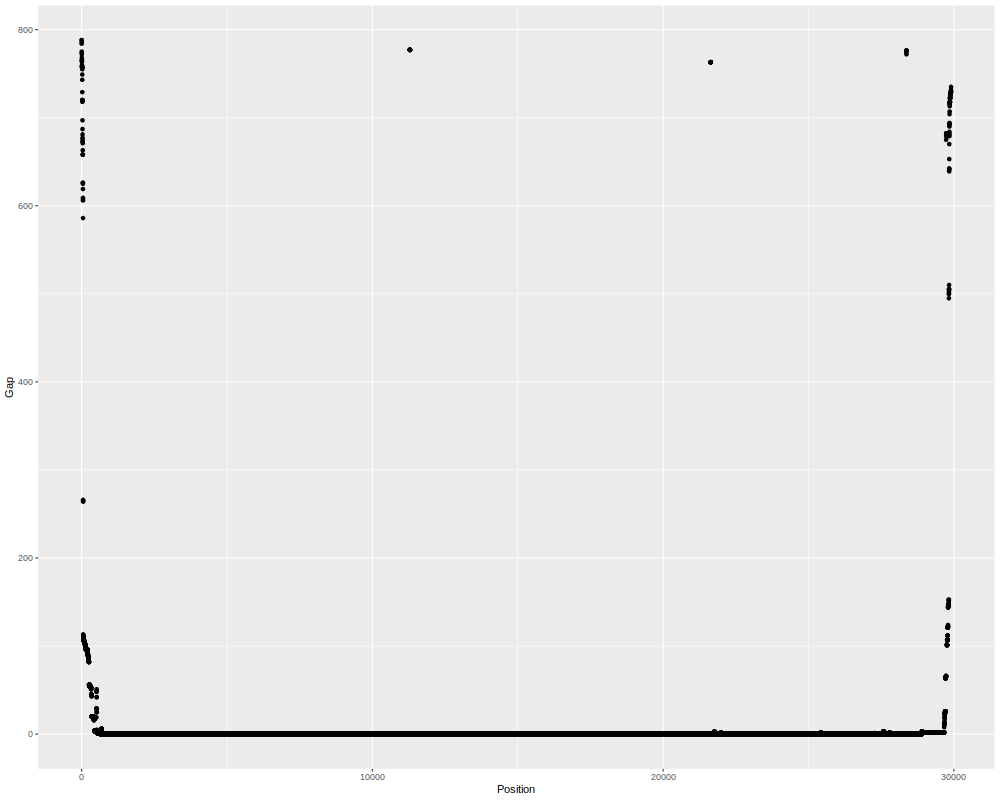

RObject{VecSxp}


In [242]:
@rput outd
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 800))
R"""
p <- ggplot(data=outd) + geom_point(aes(x=Position,y=Gap))
summary(outd)
p
"""

In [226]:
1:2

1:2

In [229]:
m = aln.M
set_dna = [DNA_N,DNA_Gap]
out = Array{Array{Int64},1}()
ctparse = 0
for clm in eachrow(m)
    cm = countmap(clm)
    N = length(clm)
    cmvals =  map( (x) -> x in keys(cm) ? cm[x] : 0, set_dna)
    push!(cmvals,N)
    push!(out,cmvals)
    ctparse += 1
    if mod(ctparse,1000) == 0
        print("Counted $ctparse columns\r")
    end
end
println("Doing transposition...")
outm = transpose(hcat(out...))
println("Done. Converting to a data frame...")
outd = DataFrame(outm,[:N,:Gap,:Total])
outd.ID=aln.names
outd

Doing transposition...
Done. Converting to a data frame...


Row,N,Gap,Total,ID
,Int64,Int64,Int64,String
1,0,179,29903,Scotland/QEUH-3C4E405/2022
2,0,179,29903,England/QEUH-3C5A530/2022
3,0,179,29903,Scotland/QEUH-3C5A7C1/2022
4,0,179,29903,England/ALDP-3C2902A/2022
5,0,194,29903,England/QEUH-3C5A8FB/2022
6,500,179,29903,Scotland/QEUH-3C2E7A8/2022
7,1,179,29903,England/PHEP-YYRT8NQ/2022
8,0,295,29903,Italy/EMR_AUSLRomagna_C030-22-29/2022
9,64,102,29903,Norway/11020/2022


In [202]:
outd

Row,N,Gap,Total
,Int64,Int64,Int64
1,0,493,496
2,0,0,496
3,0,0,496
4,0,0,496
5,0,0,496
6,0,0,496
7,0,0,496
8,0,0,496
9,0,0,496


In [194]:


#DataFrame(t(dini),[:A,:B,:C])



Row,N,Gap,Total
,Int64,Int64,Int64
1,0,493,496
2,0,0,496
3,0,0,496
4,0,0,496
5,0,0,496


In [203]:
@rput outd

Row,N,Gap,Total
,Int64,Int64,Int64
1,0,493,496
2,0,0,496
3,0,0,496
4,0,0,496
5,0,0,496
6,0,0,496
7,0,0,496
8,0,0,496
9,0,0,496


In [204]:
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 800))
R"""
ggplot(data=outd) + geom_point(aes(x=Row,y=N))
"""

RCall.REvalError: REvalError: Error in `geom_point()`:
! Problem while computing aesthetics.
ℹ Error occurred in the 1st layer.
Caused by error in `FUN()`:
! object 'Row' not found
Backtrace:
     ▆
  1. ├─base (local) `<fn>`(x)
  2. ├─ggplot2:::print.ggplot(x)
  3. │ ├─ggplot2::ggplot_build(x)
  4. │ └─ggplot2:::ggplot_build.ggplot(x)
  5. │   └─ggplot2:::by_layer(...)
  6. │     ├─rlang::try_fetch(...)
  7. │     │ ├─base::tryCatch(...)
  8. │     │ │ └─base (local) tryCatchList(expr, classes, parentenv, handlers)
  9. │     │ │   └─base (local) tryCatchOne(expr, names, parentenv, handlers[[1L]])
 10. │     │ │     └─base (local) doTryCatch(return(expr), name, parentenv, handler)
 11. │     │ └─base::withCallingHandlers(...)
 12. │     └─ggplot2 (local) f(l = layers[[i]], d = data[[i]])
 13. │       └─l$compute_aesthetics(d, plot)
 14. │         └─ggplot2 (local) compute_aesthetics(..., self = self)
 15. │           └─ggplot2:::scales_add_defaults(...)
 16. │             └─base::lapply(aesthetics[new_aesthetics], eval_tidy, data = data)
 17. │               └─rlang (local) FUN(X[[i]], ...)
 18. └─base::.handleSimpleError(...)
 19.   └─rlang (local) h(simpleError(msg, call))
 20.     └─handlers[[1L]](cnd)
 21.       └─cli::cli_abort(...)
 22.         └─rlang::abort(...)

In [22]:
# alnL = JuliaClusterAndTreeTools.Alignment("/mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade.fasta.gz")

Reading aligment /mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade.fasta.gz

Parsed 480000 sequences 
Reading alignment finished, 134575 sequences were skipped due to atypical symbols



Alignment(["Germany/BW-RKI-I-667903/2022", "Germany/BW-RKI-I-667524/2022", "England/ALDP-3C3EBE5/2022", "Germany/BW-RKI-I-667902/2022", "Denmark/DCGC-455290/2022", "Germany/BW-RKI-I-667089/2022", "England/ALDP-3C3F6D4/2022", "Germany/BW-RKI-I-667907/2022", "England/QEUH-3C5DA7A/2022", "England/QEUH-3C5EB3A/2022"  …  "Denmark/DCGC-455285/2022", "England/ALDP-3C4A278/2022", "England/PLYM-3C48FA0/2022", "Germany/BW-RKI-I-667522/2022", "England/ALDP-3C3F3A0/2022", "Germany/BW-RKI-I-667901/2022", "England/LSPA-3C3FCE1/2022", "England/LSPA-3C3EEFB/2022", "England/ALDP-3C4A296/2022", "Spain/MD-HULP-40481773/2022"], BioSymbols.DNA[DNA_Gap DNA_Gap … DNA_A DNA_A; DNA_Gap DNA_Gap … DNA_Gap DNA_Gap; … ; DNA_Gap DNA_Gap … DNA_Gap DNA_Gap; DNA_Gap DNA_Gap … DNA_Gap DNA_Gap], Int32[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], Dict{String, Int32}("Scotland/QEUH-3BF2FB5/2022" => 311832, "Portugal/PT29200/2022" => 149926, "England/DHSC-CYB5A19/2022" => 312628, "Wales/PHWC-PETBZM/2022"

LoadError: UndefVarError: alnL not defined